1. Difficulty evaluation using trajectory rewards

Visualization of the state

In [1]:
%load_ext autoreload
%autoreload 2

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR, StepLR

from copy import copy

import matplotlib
import torch
from IPython.core.display import clear_output
from torch.nn import LeakyReLU, functional as F

from framework import TrajectoryRewardsEvaluator, QEvaluator, DQNAgent, SeededGenerator
from pendulum import PendulumEnvironment, PendulumRenderer, PendulumState
from pendulum.heuristic import *
from shared_parameters import *
from utils import mean, running_average, MLP
from utils import save, load, set_matplotlib_colors

set_matplotlib_colors(matplotlib, text_color="black", label_color="white")
import matplotlib.pyplot as plt

torch.set_printoptions(sci_mode=False)

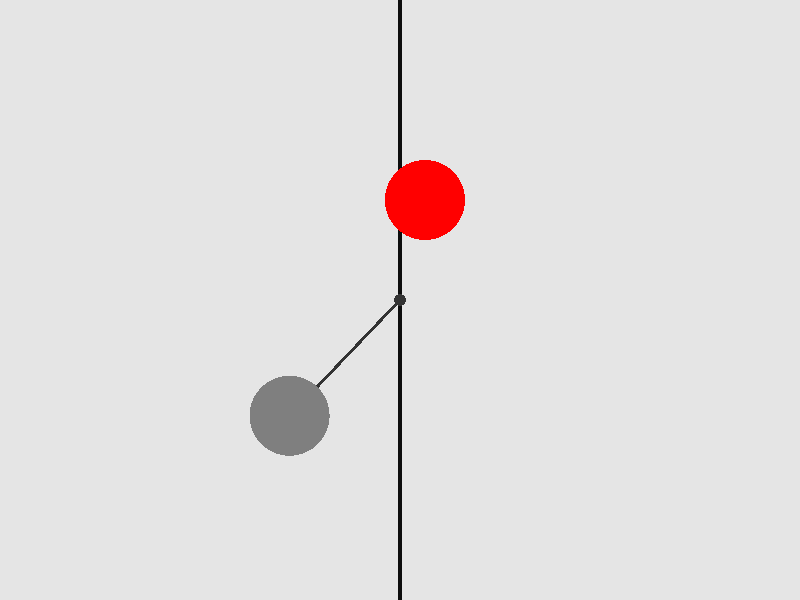

In [2]:
env = PendulumEnvironment(*pendulum_env_args, time_scale=5, step_reward=1.0, action_reward=-0.1, death_reward=-100.0)
renderer = PendulumRenderer(bob_radius, connector_length, enemy_radius, enemy_y)

renderer.render(env.get_starting_state(), to_image=True)


### Note for all difficulty estimators

Currently, we have a small embedding space (just one dimension),
thus it's possible to pre-evaluate it directly, and then use the
cached difficulty evaluations.

Within the bigger space it's not possible, and we will have to
come up with some clever way of caching, where we don't store the
evaluation for every point space, but neither perform an evaluation
each time for each point.

### Direct difficulty estimation

In [ ]:
oracle = HeuristicPendulumEvaluator(connector_length, max_angle, enemy_radius, bob_radius)
state = env.get_starting_state()
difficulty = oracle(state)

print(state.to_string())
print(f"difficulty: {difficulty.item():.3f}")

### Difficulty estimation using trajectory rewards

In [ ]:
skills = [1.0, 0.5, 0.0]
weights = [0.5, 0.25, 0.25]
agents = [HeuristicPendulumActor(enemy_radius, bob_radius, connector_length, enemy_y, skill=skill) for skill in skills]
oracle = TrajectoryRewardsEvaluator(env, agents, weights, num_evaluations=10, max_trajectory_length=20)

states = torch.vstack([env.get_starting_state() for _ in range(10)])
oracle.evaluate(states)

### Difficulty estimation using Q-values

1. Train agents, save at time steps
2. Use them in QEvaluator

In [ ]:
agent = DQNAgent(PendulumState.get_size(1), action_size=2, hidden=[8, 8], activation=LeakyReLU())
total_rewards = []
agents = []

Run next cell to train the agent until you're satisfied. Run the cell above it to save the agent

In [ ]:
# Train the agent for N iterations
agent.eval = False
loss = agent.train(env, epochs=100, max_trajectory_length=20)
agent.eval = True

for _ in range(10):
    state = env.get_starting_state()
    total_reward = 0.0

    for _ in range(20):
        action = agent.get_action(state)
        state, reward, done = env.transition(state, action)
        total_reward += reward
        if done:
            break

    total_rewards.append(total_reward)
    if len(total_rewards) > 1000:
        total_rewards.pop(0)

clear_output(wait=True)
print(f"loss: {loss}. Mean total reward: {mean(total_rewards)}")
plt.plot(total_rewards)
plt.plot(running_average(total_rewards))
plt.show()

In [ ]:
# Use this to append an agent
original = agent
agents.append(copy(agent))
print(f"Total of: {len(agents)} agents")
save(agents, "./saved_data/saved_agents.pt")

for agent in agents:
    print(list(agent.nn.parameters())[0].data)

agent = original

Now we have our agents, let's run the evaluator

In [ ]:
for agent in agents:
    agent.eval = True

weights = [0.1, 0.2, 0.3, 0.4]
oracle = QEvaluator(env, 2, agents, weights, num_evaluations=1, max_trajectory_length=20)
oracle(env.get_starting_state())

### Oracles comparison

In [4]:
# Heuristic evaluator
oracle_h = HeuristicPendulumEvaluator(connector_length, max_angle, enemy_radius, bob_radius)

# Trajectory rewards evaluator
skills = [1.0, 0.5, 0.0]
weights = [0.5, 0.25, 0.25]
agents = [HeuristicPendulumActor(enemy_radius, bob_radius, connector_length, enemy_y, skill=skill) for skill in skills]
oracle_r = TrajectoryRewardsEvaluator(env, agents, weights, num_evaluations=10, max_trajectory_length=20)

# Q-Evaluator
agents = load("./saved_data/saved_agents.pt")
for agent in agents:
    agent.eval = True
    print(list(agent.nn.parameters())[0].data)

weights = [1.0]
oracle_q = QEvaluator(env, agents, weights, num_evaluations=1, max_trajectory_length=20)

print("Difficulty evaluation of the same random state:")

state = env.get_starting_state()
print(f"State: {state}")
print()

print(f"Heuristic: {oracle_h(state).item():.4f}")
print(f"Trajectory Rewards: {oracle_r(state).item():.4f}")
print(f"Q-Evaluator: {oracle_q(state).item():.4f}")

print()
print("Difficulty of several states:")

states = torch.vstack([env.get_starting_state() for _ in range(5)])
print(f"H: {oracle_h(states)}")
print(f"R: {oracle_r(states)}")
print(f"Q: {oracle_q(states)}")

print()
print("Difficulty of the whole range")

states = []
evaluations_h = []
evaluations_r = []
evaluations_q = []
state = env.get_starting_state()
num_states = 26
for i, x in enumerate(torch.linspace(enemy_x_min, enemy_x_max, num_states)):
    print(f"Evaluating {i + 1}/{num_states}...")
    s = state.clone()
    s.enemy_x = x
    states.append(x)

    evaluations_h.append(oracle_h(s))
    evaluations_r.append(oracle_r(s))
    evaluations_q.append(oracle_q(s))

print("Done")

tensor([[-0.9580, -0.3120, -0.2828,  0.1436],
        [-0.9184, -2.8424, -0.8167,  0.4843],
        [-2.1922,  2.9781, -1.6350, -5.8470],
        [-1.6450,  6.3687,  1.9850,  5.0101],
        [-0.1670,  1.4488, -3.5070,  0.1933],
        [ 0.3482,  0.4908, -0.0913, -0.1252],
        [ 1.1303, -7.1345,  0.6171, -5.6739],
        [-1.2939, -6.1549,  0.3190,  3.3671]])
Difficulty evaluation of the same random state:
State: tensor([0.1210, 0.0500, 0.0000, 0.3610])

Heuristic: 0.2373
Trajectory Rewards: 0.3163
Q-Evaluator: 0.4287

Difficulty of several states:
H: tensor([0.5076, 0.6527, 0.0598, 0.6119, 0.4911])
R: tensor([0.3157, 0.9621, 0.6478, 0.8683, 0.7144])
Q: tensor([0.0237, 0.0398, 0.0310, 0.1224, 0.0365])

Difficulty of the whole range
Evaluating 1/26...
Evaluating 2/26...
Evaluating 3/26...
Evaluating 4/26...
Evaluating 5/26...
Evaluating 6/26...
Evaluating 7/26...
Evaluating 8/26...
Evaluating 9/26...
Evaluating 10/26...
Evaluating 11/26...
Evaluating 12/26...
Evaluating 13/26...


In [ ]:
plt.plot(states, evaluations_h)
plt.plot(states, evaluations_r)
plt.plot(states, evaluations_q)
plt.legend(["Heuristic", "Rewards", "Q"])
plt.tight_layout()
plt.show()

### Training evaluator

...using the ***Trajectory rewards*** oracle

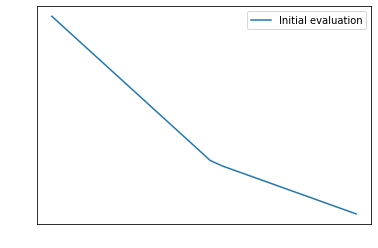

In [6]:
# Create our NN evaluator
embedding_size = 1
evaluator = MLP(in_size=embedding_size, out_size=1, hidden=[8, 8], activation=LeakyReLU())
optim = Adam(evaluator.parameters(), lr=0.01)
scheduler = StepLR(optim, 10000, 0.1)
states_ = torch.tensor(states).unsqueeze(-1)

# Example difficulty
with torch.no_grad():
    difficulty_initial = evaluator(states_)
plt.plot(states, difficulty_initial)
plt.legend(["Initial evaluation"])
plt.show()

In [137]:
# Training loop
i = 0
loss = float("inf")
real = torch.stack(evaluations_r).unsqueeze(-1)
while loss > 0.0001 and i < 10000:
    indices = torch.randperm(states_.shape[0])[:15]
    sample = states_[indices]

    d_predicted = evaluator(sample)
    d_real = real[indices]

    loss = F.mse_loss(d_real, d_predicted)

    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()

    if i % 10 == 0:
        clear_output(wait=True)
        print(f"It. {i} loss: {loss.item():.5f} {scheduler.get_last_lr()[0]}")

    i += 1

save(evaluator, "./saved_data/evaluator.plt")
print("saved to ./saved_data/evaluator.plt")

It. 9990 loss: 0.00051 0.01
saved to ./saved_data/evaluator.plt


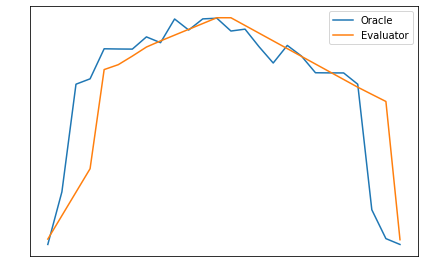

In [7]:
# Once trained we can plot the evaluation

evaluator = load("./saved_data/evaluator.plt")

plt.plot(states, evaluations_r)
plt.plot(states, evaluator(states_).detach())
plt.legend(["Oracle", "Evaluator"])
plt.tight_layout()
plt.show()

It.: 5102, difficulty_loss=0.00707 offsets_loss=0.14311


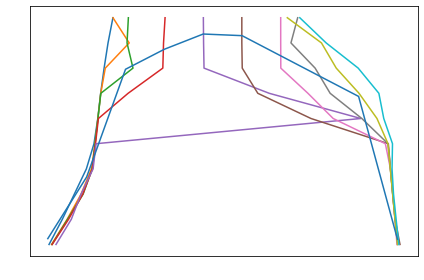

In [76]:
# Now we can train the generator
state = env.get_starting_state()
states = torch.stack([state.clone() for _ in range(100)])
enemy_xs = torch.linspace(enemy_x_min, enemy_x_max, states.shape[0]).unsqueeze(-1)
states.enemy_x = enemy_xs


bounds = torch.tensor([[enemy_x_min, enemy_x_max]])
generator = SeededGenerator(bounds, hidden=[8, 16, 16, 8], activation=LeakyReLU(), optimizer_class=Adam, lr=0.01, offsets_weight=0.25)

evaluator = load("./saved_data/evaluator.plt")

num_difficulties = 100
num_seeds = 100

# Our dataset of [difficulty, seed] inputs
difficulties = torch.linspace(0, 1, num_difficulties)
seeds = torch.linspace(enemy_x_min, enemy_x_max, num_seeds)
dataset = torch.cartesian_prod(difficulties, seeds)

# For rendering
r_difficulties = torch.linspace(0, 1, 10)
r_seeds = torch.linspace(enemy_x_min, enemy_x_max, 10)
r_dataset = torch.cartesian_prod(r_difficulties, r_seeds)

iteration = 0
loss_evaluator = float("inf")

state = env.get_starting_state()

def iterate(verbose=False):
    global dataset, iteration

    # Sample from the dataset
    indices = torch.randperm(dataset.shape[0])[:1000]
    sample = dataset[indices]

    # Generate levels
    generated_levels = generator(sample)

    d_out = evaluator(generated_levels)

    # Train the generator on the evaluated difficulty
    loss_difficulty, loss_offsets = generator.update(d_out)

    iteration += 1

    if verbose:
        clear_output(wait=True)
        print(f"It.: {iteration}, "
              f"difficulty_loss={loss_difficulty.item():.5f} "
              f"offsets_loss={loss_offsets.item():.5f}")

        generated_states = generator(r_dataset).detach()

        d_out = evaluator(generated_states).detach()

        collected = torch.hstack((r_dataset, generated_states, d_out))

        fix, ax = plt.subplots()

        for i in range(r_seeds.shape[0]):
            selected = collected[i::r_difficulties.shape[0], :]
            ds, xs = selected[:, 0], selected[:, 2]
            ax.plot(xs, ds)

        ax.plot(r_seeds, evaluator(r_seeds.unsqueeze(-1)).detach())

        plt.tight_layout()

        plt.show()


iterate()

try:
    for _ in range(100):
        for _ in range(50):
            iterate()
        iterate(True)
except KeyboardInterrupt:
    pass

iterate(True)

It.: 15304, difficulty_loss=0.09935 offsets_loss=0.10062


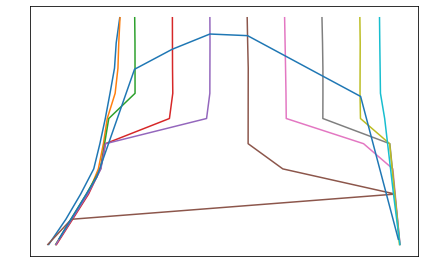

In [68]:
try:
    for _ in range(100):
        for _ in range(50):
            iterate()
        iterate(True)
except KeyboardInterrupt:
    pass

iterate(True)